In [1]:
%%time
# Python 2.7

%matplotlib nbagg
%matplotlib inline 

import sys
sys.path.append('..')
print(sys.version)

import os
import cPickle 
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import theano
import theano.tensor as T
import lasagne 
import lasagne.layers as L
import parmesan
import cPickle as pickle

from sklearn.utils import shuffle

import tools as tls
from data_loaders import svhn



/home/icarus/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


2.7.12 |Anaconda custom (64-bit)| (default, Jul  2 2016, 17:42:40) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 35.0% of memory, cuDNN 5105)


CPU times: user 2.01 s, sys: 1.21 s, total: 3.22 s
Wall time: 6.74 s


[Install Parmasan](https://github.com/casperkaae/parmesan)

    git clone https://github.com/casperkaae/parmesan.git
    cd parmesan
    python setup.py develop

In [2]:
### GLOBAL PARAMETERS ###
plot_train   = True
using_shared = False

### META - HOW THE PROGRAM WORKS

np.random.seed(1234) # reproducibility


### CONSTANTS
dataset = 'MNIST'
#dataset = 'SVHN'
print('dataset = {}'.format(dataset))

if dataset == 'SVHN':    
    file_name = 'data_svhn_c10' # assumes '.pkl'
    IMG_LEN = 32
    IMG_DEPTH = 3
    cmap = None
elif dataset == 'MNIST':
    IMG_LEN = 28
    IMG_DEPTH = 1
    cmap = 'gray'
    


dataset = MNIST


In [3]:
### PLOT SETTINGS

plt.rcParams["figure.figsize"] = (8,5)
font_size = 12
plt.rc('font',   size=font_size)       # controls default text sizes
plt.rc('axes',   titlesize=font_size)  # fontsize of the axes title
plt.rc('axes',   labelsize=font_size)  # fontsize of the x any y labels
plt.rc('xtick',  labelsize=font_size)  # fontsize of the tick labels
plt.rc('ytick',  labelsize=font_size)  # fontsize of the tick labels
plt.rc('legend', fontsize=font_size)   # legend fontsize
plt.rc('figure', titlesize=font_size)  # # size of the figure title


In [4]:
# %%time
### LOAD DATA

if dataset == 'SVHN':
    full_path = os.path.join(os.getcwd(), 'data')
    full_path = os.path.join(full_path, file_name)
    full_path  += '.pkl'
    print(full_path)

    with open(full_path, 'rb') as f:
        x_trai, t_trai, x_vali, t_vali, x_test, t_test = pickle.load(f)

    x_trai = x_trai/255
    x_vali = x_vali/255
    x_test = x_test/255


elif dataset == 'MNIST':
    full_path = os.path.join(os.getcwd(), 'data')
    full_path = os.path.join(full_path  , 'mnist.npz')

    data = np.load(full_path)
    x_trai = data['X_train'].astype('float32')
    t_trai = data['y_train'].astype('int32')

    x_vali = data['X_valid'].astype('float32')
    t_vali = data['y_valid'].astype('int32')

    x_test = data['X_test'].astype('float32')
    t_test = data['y_test'].astype('int32')


    t_trai = tls.onehot(t_trai, 10)
    t_vali = tls.onehot(t_vali, 10)
    t_test = tls.onehot(t_test, 10)



### CHECK DATA
num_classes = t_trai.shape[1]
print('Number of classes {}'.format(num_classes))

num_features = x_trai[0].shape[0]
print('Number of features {}'.format(num_features))

print('')
print('Train shape: ', 
      x_trai.shape, t_trai.shape)

print('Valid shape: ', 
      x_vali.shape, t_vali.shape)

print('Test shape:  ', 
      x_test.shape, t_test.shape)

print('{}'.format(type(x_trai)))
print('{}'.format(type(x_vali)))
print('{}'.format(type(x_test)))
print('')

print('Prior (percent)')
print(np.round(np.sum(t_trai, axis=0)/t_trai.shape[0]*1000)/10.)
print(np.round(np.sum(t_test, axis=0)/t_test.shape[0]*1000)/10.)


print('Size of total dataset: {:.2f} MB'.format(
        (
              sys.getsizeof(x_trai)
            + sys.getsizeof(t_trai)
            + sys.getsizeof(x_vali)
            + sys.getsizeof(t_vali)
            + sys.getsizeof(x_test)
            + sys.getsizeof(t_test)
        )/1.0e6))


Number of classes 10
Number of features 784

('Train shape: ', (50000, 784), (50000, 10))
('Valid shape: ', (10000, 784), (10000, 10))
('Test shape:  ', (10000, 784), (10000, 10))
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>

Prior (percent)
[  9.9  11.4   9.9  10.2   9.7   9.    9.9  10.4   9.7  10. ]
[  9.8  11.4  10.3  10.1   9.8   8.9   9.6  10.3   9.7  10.1]
Size of total dataset: 225.12 MB


In [5]:
# ### LAZY REDUCTION OF DATA SET SIZE
# x_trai = x_trai[:10000]
# t_trai = t_trai[:10000]

# x_trai = x_trai[:10000]
# t_trai = t_trai[:10000]

# x_trai = x_trai[:10000]
# t_trai = t_trai[:10000]



In [6]:
# Generate a subset of labeled data points

num_labeled = 100 # per class
if dataset=='MNIST':
    num_labeled=10

idxs_train_l = []
for i in range(num_classes):
    idxs = np.where(np.argmax(t_trai,axis=-1) == i)[0]
    idxs_train_l += np.random.choice(idxs, size=num_labeled).tolist()

x_train_l = x_trai[idxs_train_l].astype('float32')
t_train_l = (t_trai[idxs_train_l,:]).astype('float32')

In [7]:
### More data checks
# Ensure that we have one hot encoding, and that the 
print('Label check')
print(t_vali[:10,:])
print(np.where(t_trai == 1)[1][:10])

print("If you don't get a 10xNUM_CLASS matrix, and a list with the",
      "index of the 1 of each row, something went wrong.")

print
print('Input check')
### Ensure that the data is scalled appropriately (between 0 and 1)

print('\nMaximum training value: {}'.format(np.max(x_trai)))
if np.max(x_trai) > 1:
    print('WARNING!! Maximum value in input data is {}'.format(np.max(x_trai)))
else:
    print('Input: fine')

Label check
[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]]
[5 0 4 1 9 2 1 3 1 4]
("If you don't get a 10xNUM_CLASS matrix, and a list with the", 'index of the 1 of each row, something went wrong.')

Input check

Maximum training value: 0.99609375
Input: fine


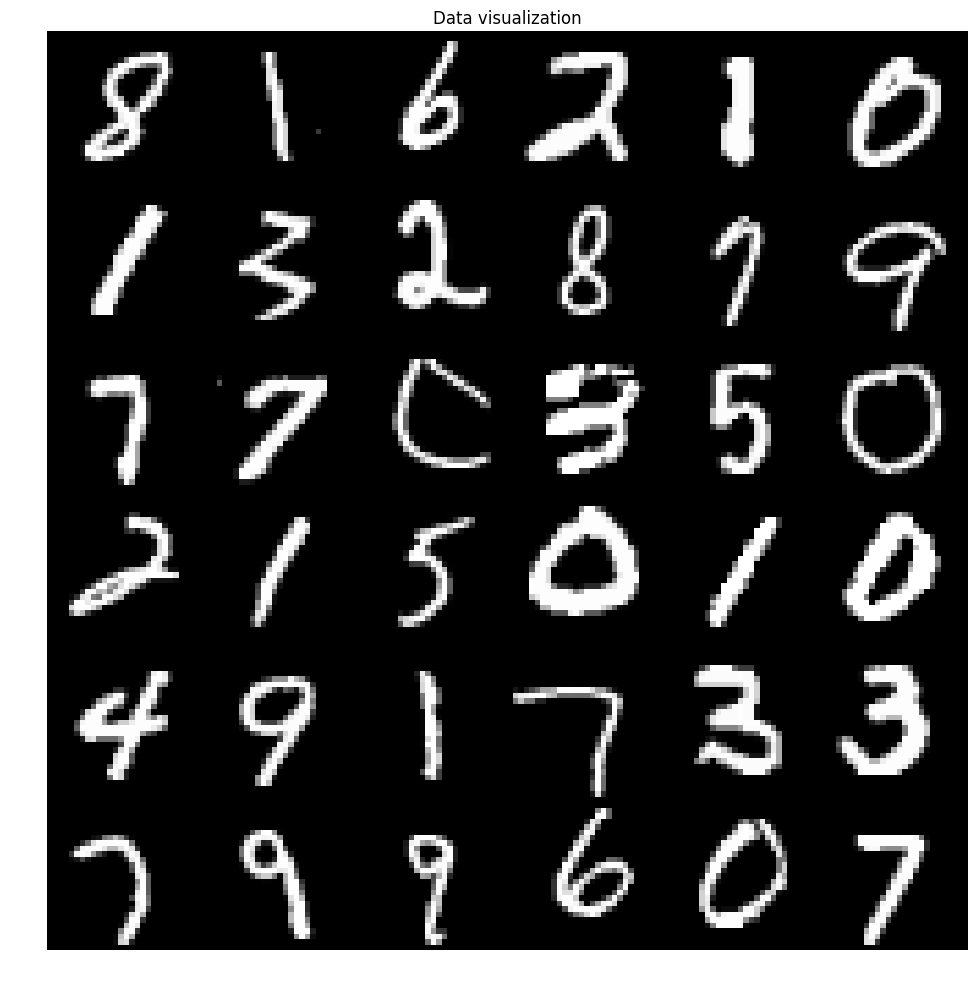

[[ 8.  1.  6.  2.  1.  0.]
 [ 1.  3.  2.  8.  7.  9.]
 [ 7.  7.  0.  3.  5.  0.]
 [ 2.  1.  5.  0.  1.  0.]
 [ 4.  9.  1.  7.  3.  3.]
 [ 7.  9.  9.  6.  0.  7.]]


In [8]:
### VISUALIZE 
canv, lab = tls.plot_svhn(x_trai, t_trai, t=6, IMG_LEN=IMG_LEN, 
                          IMG_DEPTH=IMG_DEPTH, cmap=cmap)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(canv, cmap=cmap, interpolation='nearest')

ax.set_title('Data visualization')
ax.axis('off')
plt.tight_layout()
plt.show()

print(lab) # The labels associated with the plot

In [9]:
### HYPER PARAMETERS
# VOLATILE HP
learning_rate = 1e-3
smooth_factor=0
L1 = 0
L2 = 0#1e-4

samples_to_process = 1e10
val_interval=1e5
batch_size = 500


# ARCHITECTURE
hid_size = 500
fraction = 0.1
num_latent_1 = round(hid_size*fraction)
num_latent=num_latent_1
#num_latent_1 = 300
skip_connections=True
# deconv_rec=False
augmented_train=False


pretraining=False
save_weights = False
M1_model_name = 'models/M1_pretrained.npz'

M2_model_name_in = 'models/M2_pretrained.npz'
M2_model_name_out = 'models/M2_pretrained'
load_M2 = True
save_M2 = False


# conv_net_class=True

# STABLE HP
eq_size = 1
iw_size = 1

# Weigth elements in likelihood 
Alpha_in=0.1
Beta_in=0#1
KL_weigth_sup_in=1
KL_weigth_uns_in=1

rec_scale=1

#Prior y
# prior_y=np.mean(t_trai,axis=0).reshape(1,-1).astype('float32') # True prior is problematic
prior_y = np.asarray([1/float(num_classes) for i in range(num_classes)]).astype('float32')#flat prior
prior_y = prior_y.reshape(1,-1)

In [10]:
prior_y.shape

(1, 10)

In [11]:
### HELPER FUNCTIONS
from lasagne.objectives import squared_error
from lasagne.nonlinearities import leaky_rectify, rectify, sigmoid,softmax,elu
from parmesan.layers import SampleLayer

def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes)).astype('float32')
    for row, col in enumerate(t):
        out[row, col] = 1
    return out


# c = -0.5 * np.log(2*np.pi)
clip = lambda x: T.clip(x,-10,10) #used to limit the variance (why?)

def log_bernoulli(target, output, eps=1e-8):
    """
    Computes the binary cross-entropy between a target and 

    Use eps if you don't want to alow values ==0, ==1
    """

#     output = T.clip(output, eps, 1.0 - eps)
#     return -T.nnet.binary_crossentropy(output, target)
    return (target * T.log(output + eps) + (1.0 - target) * T.log(1.0 - output + eps))
#     return (target * T.log(output)       + (1.0 - target) * T.log(1.0 - output))




def kl_normal_2_stdnormal(mu, lv):
    """Compute the KL divergence from the standard normal dist"""
    return - 0.5 * (1 + lv - mu**2 - T.exp(lv))


def load_model(model_name, network):
    """network is the bottom most layer of the model"""
    with np.load(model_name) as f:
        param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    # param_values[0] = param_values[0].astype('float32')	
    param_values = [param_values[i].astype('float32') for i in range(len(param_values))]
    lasagne.layers.set_all_param_values(network, param_values)

def save_model(model_name, network):
    """network is the bottom most layer of the model"""
    np.savez(model_name, *L.get_all_param_values(network))

def M1_likelihood(x,x_rec,sigma_1,mu_1,KL_weigth=1):
    
    reconstruction_cost = log_bernoulli(x, x_rec).sum(axis=1)
    
    KL_1 = kl_normal_2_stdnormal(mu_1, sigma_1).sum(axis=1)
    
    LL = reconstruction_cost - KL_1 * KL_weigth
    return LL, reconstruction_cost, KL_1

def M2_likelihood(x,x_rec,sigma_1,mu_1, sigma_2,mu_2,KL_weigth=1):
    
    reconstruction_cost = log_bernoulli(x, x_rec).sum(axis=1)
    
    KL_1 = kl_normal_2_stdnormal(mu_1, sigma_1).sum(axis=1)
    KL_2 = kl_normal_2_stdnormal(mu_2, sigma_2).sum(axis=1)

    
    LL = reconstruction_cost - (KL_1+KL_2) * KL_weigth
    return LL, reconstruction_cost, KL_1,KL_2


def LogSumExp(x, axis=None, keepdims=False):
    ''' Numerically stable theano version of the Log-Sum-Exp trick'''
    x_max = T.max(x, axis=axis, keepdims=True)

    preres = T.log(T.sum(T.exp(x - x_max), axis=axis, keepdims=keepdims))
    return preres + x_max.reshape(preres.shape)

def img_transform(x,reverse=False):
    if reverse:
        x=x.swapaxes(1,2)
        x=x.swapaxes(2,3)
        x=x.reshape((x.shape[0],IMG_LEN*IMG_LEN*IMG_DEPTH))
    else:
        x=x.reshape((x.shape[0],IMG_LEN, IMG_LEN, IMG_DEPTH))
        x=x.swapaxes(2,3)
        x=x.swapaxes(1,2)
    return x


def module(l_in,module_type,out_size,hid_size=hid_size,skip_connections=skip_connections):

    
    l_1   = L.DenseLayer(l_in, 
                        num_units=hid_size,
                        nonlinearity=elu)#,
    l_2   = L.DenseLayer(l_1,
                            num_units=hid_size,
                            nonlinearity=elu)#,
    if skip_connections:
        l_2=L.ConcatLayer([l_1,l_2])
    
    if module_type=='latent_generator':
        mu   = L.DenseLayer(l_2,
                            num_units=out_size,
                            nonlinearity=None)#,

        sigma   = L.DenseLayer(l_2,
                            num_units=out_size,
                            nonlinearity=clip)#,
        return mu,sigma
    if module_type=='recon_generator':
        l_out    = L.DenseLayer(l_2, 
                            num_units=out_size,
                            nonlinearity=sigmoid)
        return l_out
    if module_type=='classifier':
        #l_2=L.DropoutLayer(l_2,p=0.2)
        l_out    = L.DenseLayer(l_2, 
                            num_units=out_size,
                            nonlinearity=softmax)
        return l_out
    

In [12]:
# %%time
### CREATE MODEL
from lasagne.nonlinearities import leaky_rectify, rectify, sigmoid,softmax
from parmesan.layers import SampleLayer
### CLASSIFIER
l_in_x   = L.InputLayer(shape=(None, num_features))#, name='l_in_x')
l_in_y   = L.InputLayer(shape=(None, num_classes))#, name='l_in_y')
l_in_z_1   = L.InputLayer(shape=(None, num_latent))#, name='l_in_y'
l_in_z_2   = L.InputLayer(shape=(None, num_latent))#, name='l_in_y')

### M1 ENCODER 
mu_1,sigma_1 = module(l_in_x,
                     module_type='latent_generator',
                     out_size=num_latent)
l_z_1        = SampleLayer(mean=mu_1, 
                         log_var=sigma_1, 
                         eq_samples=eq_size, 
                         iw_samples=iw_size)#,
### M1 DECODER
x_rec_M1     = module(l_z_1,
                     module_type='recon_generator',
                     out_size=num_features)
### Classifier
y_out       = module(l_in_z_1,
                     module_type='classifier',
                     out_size=num_classes
                        #,hid_size=num_latent*2
                    )

## Entering of Y
l_z_1_concat = L.ConcatLayer([l_in_z_1,l_in_y])

mu_2,sigma_2 = module(l_z_1_concat,
                     module_type='latent_generator',
                     out_size=num_latent
                     #,hid_size=num_latent*2
                     )

l_z_2        = SampleLayer(mean=mu_2, 
                         log_var=sigma_2, 
                         eq_samples=eq_size, 
                         iw_samples=iw_size)#,

### M2 DECODER
l_z_2_concat = L.ConcatLayer([l_z_2,l_in_y])


#### The part below is removed tempoarally in order to obtain faster convergence
# mu_1_dec , sigma_1_dec = module(l_z_2_concat,
#                      module_type='latent_generator',
#                      out_size=num_latent)

# l_z_1_dec    = SampleLayer(mean=mu_1_dec, 
#                          log_var=sigma_1_dec, 
#                          eq_samples=eq_size, 
#                          iw_samples=iw_size)#,

# l_z_1_dec_con= L.ConcatLayer([l_z_1_dec,l_in_y])

x_rec_M2     = module(l_z_2_concat,
                     module_type='recon_generator',
                     out_size=num_features
                     #,hid_size=num_latent*2
                     )


/home/icarus/anaconda2/lib/python2.7/site-packages/lasagne/init.py:100: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  low=self.range[0], high=self.range[1], size=shape))
/home/icarus/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


In [13]:
# %%time
from lasagne.objectives import categorical_crossentropy, categorical_accuracy
from theano.tensor.shared_randomstreams import RandomStreams

##################GENERATING RECONSTRUCTIONS AND CLASSES

sym_x = T.matrix('x') # (batch_size x 3072)
sym_z = T.matrix('z') # Latent variable (batch_size x num_latent)
sym_y = T.matrix('y_l') # Latent variable (batch_size x num_classes)
sym_x_l = T.matrix('x_l') # Latent variable (batch_size x 3072)
KL_weigth_sup = T.fscalar('KL_weigth_sup') 
KL_weigth_uns = T.fscalar('KL_weigth_uns')
Alpha = T.fscalar('Alpha') 
Beta = T.fscalar('Beta')

####### Repeatition of data for unsupervised learning

py=T.dot(T.ones((sym_x.shape[0],1)),prior_y)

streamer=RandomStreams()
#####################SUPERVISED###################
if augmented_train:
    x_augmented_l=streamer.binomial(n=1, p=sym_x_l,size=sym_x_l.shape).astype(theano.config.floatX)
    mu_1_l, sigma_1_l, x_rec_M1_l,l_z_1_l = L.get_output([mu_1,sigma_1,x_rec_M1,l_z_1
                        ],{l_in_x:x_augmented_l},deterministic = False) #Encoder
else: 
    mu_1_l, sigma_1_l, x_rec_M1_l,l_z_1_l = L.get_output([mu_1,sigma_1,x_rec_M1,l_z_1
                    ],{l_in_x:sym_x_l},deterministic = False) #Encoder
y_train_l = L.get_output([y_out
                        ],{l_in_z_1:l_z_1_l},deterministic = False)[0] #Encoder

x_rec_M2_l, mu_2_l, sigma_2_l = L.get_output([x_rec_M2,mu_2,sigma_2],#DECODER
                                           {l_in_z_1:l_z_1_l,l_in_y:sym_y}, deterministic = False)


#Likelihood
    
M2_like_l,rec_M2_l,KL_2_M1_l = M1_likelihood(sym_x_l, x_rec_M2_l, sigma_2_l, mu_2_l, KL_weigth_sup)
# M2_like_l,rec_M2_l,KL_1_M2_l,KL_2_M2_l = M2_likelihood(x_train_l, x_rec_M2_l,
#                                                  sigma_1_l, mu_1_l,
#                                                  sigma_2_l, mu_2_l,
#                                                  KL_weigth_sup)


smooth_y=(1-smooth_factor)*sym_y + smooth_factor*T.dot(T.ones((sym_y.shape[0],1)),prior_y) # Toke --> stochastic here

LL_train_l=T.mean(M2_like_l*rec_scale+Alpha*T.sum(smooth_y*T.log(y_train_l+1e-8))) 


#############UNSUPERVISED####################
if augmented_train:
    x_augmented_u=streamer.binomial(n=1,p=sym_x,size=sym_x.shape).astype(theano.config.floatX)
    mu_1_u, sigma_1_u, x_rec_M1_u,l_z_1_u = L.get_output([mu_1,sigma_1,x_rec_M1,l_z_1
                    ],{l_in_x:x_augmented_u},deterministic = False) #Encoder
else:    
    mu_1_u, sigma_1_u, x_rec_M1_u,l_z_1_u = L.get_output([mu_1,sigma_1,x_rec_M1,l_z_1
                        ],{l_in_x:sym_x},deterministic = False) #Encoder
    
y_train_u = L.get_output([y_out
                        ],{l_in_z_1:l_z_1_u},deterministic = False)[0] #Encoder
    
#Splitting on label
t_eye = T.eye(num_classes, k=0)
t_u = t_eye.reshape((num_classes, 1, num_classes)).repeat(sym_x.shape[0], axis=1).reshape((-1, num_classes))
z_1_u = l_z_1_u.reshape((1, l_z_1_u.shape[0], l_z_1_u.shape[1])).repeat(num_classes, axis=0).reshape((-1, l_z_1_u.shape[1]))
x_u = sym_x.reshape((1, sym_x.shape[0], sym_x.shape[1])).repeat(num_classes, axis=0).reshape((-1, sym_x.shape[1]))

x_rec_M2_u, mu_2_u, sigma_2_u = L.get_output([x_rec_M2,mu_2,sigma_2],#DECODER
                                           {l_in_z_1:z_1_u,l_in_y:t_u}, deterministic = False)

#Replicate to fit dimentions of x_u
mu_1_rep_u = mu_1_u.reshape((1, mu_1_u.shape[0], mu_1_u.shape[1])).repeat(num_classes, axis=0).reshape((-1, mu_1_u.shape[1]))
sigma_1_rep_u = sigma_1_u.reshape((1, sigma_1_u.shape[0], sigma_1_u.shape[1])).repeat(num_classes, axis=0).reshape((-1, sigma_1_u.shape[1]))


#Likelihood
M1_like_u,rec_M1_u,KL_1_M1_u = M1_likelihood(sym_x, x_rec_M1_u, sigma_1_u, mu_1_u, KL_weigth_uns)
M2_like_u,rec_M2_u,KL_2_M2_u = M1_likelihood(x_u, x_rec_M2_u, sigma_2_u, mu_2_u, KL_weigth_uns)

# M2_like_u,rec_M2_u,KL_1_M2_u,KL_2_M2_u = M2_likelihood(x_u, x_rec_M2_u,
#                                                  sigma_1_rep_u, mu_1_rep_u,
#                                                  sigma_2_u, mu_2_u,
#                                                  KL_weigth_uns)
#M2_likelihood
M2_like_u = M2_like_u.reshape((num_classes,sym_x.shape[0])).T*rec_scale
M2_like_u+=-T.log(y_train_u+1e-8)*Beta+T.log(py)
LL_train_u=T.mean(T.sum(y_train_u*M2_like_u,axis=1))


################## EVALUATION##############################
mu_1_eval, sigma_1_eval, x_rec_M1_eval,l_z_1_eval = L.get_output([mu_1,sigma_1,x_rec_M1,l_z_1
                        ],{l_in_x:sym_x},deterministic = True) #Encoder
y_train_eval = L.get_output([y_out
                        ],{l_in_z_1:l_z_1_eval},deterministic = True)[0] #Encoder
    
#Splitting on label
t_eye = T.eye(num_classes, k=0)
t_eval = t_eye.reshape((num_classes, 1, num_classes)).repeat(sym_x.shape[0], axis=1).reshape((-1, num_classes))
z_1_eval = l_z_1_eval.reshape((1, l_z_1_eval.shape[0], l_z_1_eval.shape[1])).repeat(num_classes, axis=0).reshape((-1, l_z_1_eval.shape[1]))
x_eval = sym_x.reshape((1, sym_x.shape[0], sym_x.shape[1])).repeat(num_classes, axis=0).reshape((-1, sym_x.shape[1]))

x_rec_M2_eval, mu_2_eval, sigma_2_eval = L.get_output([x_rec_M2,mu_2,sigma_2],#DECODER
                                           {l_in_z_1:z_1_eval,l_in_y:t_eval}, deterministic = True)



#Likelihood

M1_like_eval,rec_M1_eval,KL_1_M1_eval = M1_likelihood(sym_x, x_rec_M1_eval, sigma_1_eval, mu_1_eval, KL_weigth_uns)

#Replicate to use for M2
mu_1_rep_eval = mu_1_eval.reshape((1, mu_1_eval.shape[0], mu_1_eval.shape[1])).repeat(num_classes, axis=0).reshape((-1, mu_1_eval.shape[1]))
sigma_1_rep_eval = sigma_1_eval.reshape((1, sigma_1_eval.shape[0], sigma_1_eval.shape[1])).repeat(num_classes, axis=0).reshape((-1, sigma_1_eval.shape[1]))


M2_like_eval,rec_M2_eval,KL_1_M2_eval = M1_likelihood(x_eval, x_rec_M2_eval, sigma_2_eval, mu_2_eval, KL_weigth_uns)

# M2_like_eval,rec_M2_eval,KL_1_M2_eval,KL_2_M2_eval = M2_likelihood(x_eval, x_rec_M2_eval,
#                                                  sigma_1_rep_eval, mu_1_rep_eval,
#                                                  sigma_2_eval, mu_2_eval,
#                                                  KL_weigth_uns)
#M2_likelihood
M2_like_eval = M2_like_eval.reshape((num_classes,sym_x.shape[0])).T*rec_scale
M2_like_eval+=-T.log(y_train_eval+1e-8)*Beta+T.log(py)
LL_train_eval=T.mean(T.sum(y_train_eval*M2_like_eval,axis=1))



### Combining likelihood
LL=LL_train_u+LL_train_l

In [14]:
# f_temp=theano.function([sym_x, In(KL_weigth_uns, value=KL_weigth_uns_in)
#                                 ],[M1_like_eval])
# out=f_temp(x_train_l)
# print(out[0].shape)

In [15]:
#Define variables to output
#LL_train,LL_train_u,LL_train_l allready defined
certainty_class_eval=T.mean(T.max(y_train_eval,axis=-1))
prob_recon_eval=T.exp(M2_like_eval-LogSumExp(M2_like_eval,axis=-1,keepdims=True))
certainty_recon_eval=T.mean(T.max(prob_recon_eval,axis=-1))
# mean_var_eval=T.mean(lv_train_eval)
recon_class_same_eval=categorical_accuracy(prob_recon_eval,y_train_eval).mean()


#Evaluation output
# prob_recon_eval=T.exp(LL_rec_eval-LogSumExp(LL_rec_eval,axis=-1,keepdims=True))

#create KL divergence mean unwiegthed - IMPROVE
# KL_train_u = KL_train_u.reshape((num_classes,sym_x.shape[0])).T
# KL_train_l = KL_train_l.reshape((num_classes,sym_x_l.shape[0])).T
# mean_KL_train_u=T.sum(y_train_u*KL_train_u,axis=1).mean()
# mean_KL_train_l=T.sum(sym_y*KL_train_l,axis=1).mean()


In [16]:
%%time
from theano import In
### M1 train
M1_params = L.get_all_params([x_rec_M1], trainable=True)
M1_grads  = T.grad(-M1_like_u.mean(), M1_params)
M1_updates    = lasagne.updates.adam(M1_grads, M1_params,
                                  learning_rate=learning_rate)

f_train_M1 = theano.function(inputs=[sym_x,
                                 In(KL_weigth_uns, value=KL_weigth_uns_in),
                                 ],
                          outputs=[M1_like_u,x_rec_M1_u],
                          updates=M1_updates)
f_eval_M1 = theano.function(inputs=[sym_x,
                                 In(KL_weigth_uns, value=KL_weigth_uns_in),
                                 ],
                          outputs=[M1_like_eval.mean(),KL_1_M1_eval.mean()])

f_reconstruction_M1 = theano.function(inputs=[sym_x], outputs=[x_rec_M1_eval,l_z_1_eval])

### M2 train
M2_params = L.get_all_params([y_out, x_rec_M2], trainable=True)
# TO-DO Add L2-reg
#reg_l2 = lasagne.regularization.regularize_network_params([l_z_1, l_dec_con_out,l_out_class],lasagne.regularization.l2)

M2_grads  = T.grad(-LL, M2_params)
M2_updates    = lasagne.updates.adam(M2_grads, M2_params,
                                  learning_rate=learning_rate)

f_train_M2 = theano.function(inputs=[sym_x,sym_x_l,sym_y,
                                In(KL_weigth_uns, value=KL_weigth_uns_in),
                            In(KL_weigth_sup, value=KL_weigth_sup_in),
                        In(Beta, value=Beta_in),In(Alpha, value=Alpha_in)],
                          outputs=[LL,M2_like_u,M2_like_l],
                          updates=M2_updates)

f_eval_M2 = theano.function(inputs=[sym_x,
                                  In(KL_weigth_uns, value=KL_weigth_uns_in),
                                  In(Beta, value=Beta_in)],outputs=[y_train_eval,LL_train_eval
                                                                    ,certainty_class_eval,certainty_recon_eval,recon_class_same_eval
                                                                   ,KL_1_M1_eval.mean(),KL_1_M2_eval.mean(),prob_recon_eval
                                                                   ,T.sqr(mu_2_eval).mean(), sigma_2_eval.mean() 
                                                                   ])

f_reconstruction_M2 = theano.function(inputs=[sym_x], outputs=[x_rec_M2_eval,l_z_1_eval,mu_2_eval])


# ### M2+M1 unsupervised train
M2_params_uns = L.get_all_params([l_z_1,y_out, x_rec_M2], trainable=True)
M2_grads_uns  = T.grad(-LL_train_u+kl_normal_2_stdnormal(mu_1_u, sigma_1_u).sum(axis=1).mean(), M2_params_uns)
M2_updates_uns    = lasagne.updates.adam(M2_grads_uns, M2_params_uns,
                                  learning_rate=learning_rate)

f_train_M2_uns = theano.function(inputs=[sym_x,
                                In(KL_weigth_uns, value=KL_weigth_uns_in),
                        In(Beta, value=Beta_in)],
                          outputs=[],
                          updates=M2_updates_uns)



CPU times: user 28.4 s, sys: 1e+03 ms, total: 29.4 s
Wall time: 29.5 s


In [17]:
# ## Unsupervised Gradient
# M2_like_u = M2_like_u.reshape((num_classes,sym_x.shape[0])).T*rec_scale
# M2_like_u+=-T.log(y_train_u+1e-8)*Beta+T.log(py)
# LL_train_u=T.mean(T.sum(y_train_u*M2_like_u,axis=1))
# uns_grad=T.grad(-LL_train_u,M2_params)
# ## Reconstrction Gradient supervised
# rec_M2_u_out=rec_M2_u.reshape((num_classes,sym_x.shape[0])).T
# rec_M2_u_out+=-T.log(y_train_u+1e-8)*Beta+T.log(py)
# LL_rec_u_out=T.mean(T.sum(y_train_u*rec_M2_u_out,axis=1))
# rec_u_grad=T.grad(-LL_rec_u_out,M2_params)
# uns_rec_grad=T.grad(-LL_train_u,M2_params)

# ## Supervised gradient
# M2_like_l,rec_M2_l,KL_2_M1_l = M1_likelihood(x_train_l, x_rec_M2_l, sigma_2_l, mu_2_l, KL_weigth_sup)

# smooth_y=(1-smooth_factor)*t_train_l + smooth_factor*T.dot(T.ones((t_train_l.shape[0],1)),prior_y) # Toke --> stochastic here

# cost_l_no_class=T.mean(M2_like_l*rec_scale) 
# l_no_class_grad=T.grad(-cost_l_no_class,x_rec_M2)
# l_rec_grad=T.grad(-T.mean(rec_M2_l),x_rec_M2)

# class_params = L.get_all_params([y_out], trainable=True)
# l_class_grad=T.grad(-Alpha*T.sum(smooth_y*T.log(y_train_l+1e-8)),class_params)
# f_grads=theano.function([sym_x,sym_x_l,sym_y],In(KL_weigth_uns, value=KL_weigth_uns_in),
#                             In(KL_weigth_sup, value=KL_weigth_sup_in),
#                         In(Beta, value=Beta_in),In(Alpha, value=Alpha_in), outputs=[uns_rec_grad,rec_u_grad,l_no_class_grad,l_rec_grad,l_class_grad])

In [18]:
# out=f_grad(x_train_l)
# for i in range(len(out)):
#     print(len(out[i]))
#print(f_eval_M2(x_train_l)[0].shape)
#print(f_reconstruction_M1(x_train_l)[0].shape)


In [19]:
def augment_image(x,eps=1e-3, noise_sigma=0.1):
    x_trans=np.log((x+eps)/(1-x+eps))
    x_trans=x_trans.reshape((x.shape[0],IMG_LEN,IMG_LEN,IMG_DEPTH))
    for i in range(IMG_DEPTH):
        x_trans[:,:,:,i]+=np.random.normal(0,noise_sigma)
    x_trans=(x_trans+np.random.normal(0,noise_sigma))*np.exp(np.random.normal(0,noise_sigma*4))+np.random.normal(0,noise_sigma)
    
    x_trans+=np.random.normal(0,noise_sigma, (x_trans.shape)).astype('float32')
    
    x_out=(np.exp(x_trans)/(1+np.exp(x_trans))).reshape((x.shape[0],IMG_LEN*IMG_LEN*IMG_DEPTH))
    x_out=np.nan_to_num(x_out) 
    x_out=np.clip(x_out,0,1)

    return x_out
def pretty_print(title,output_dict,var_list,var_list_extra=[],M_type='_M2',show=True):
    color_list=["blue","red","green","cyan","magenta","yellow","black"]
    plt.xlabel('Updates')
    for i in range(len(var_list)):
        plt.plot(output_dict['samples_processed'+M_type], output_dict[var_list[i]], 
                 color=color_list[i], label=var_list[i])
        if i<len(var_list_extra):
            plt.plot(output_dict['samples_processed'+M_type], output_dict[var_list_extra[i]], 
                 color=color_list[i], label=var_list_extra[i],linestyle="--")
    
    plt.legend(loc=2)

    plt.title(title)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.grid('on')
    plt.tight_layout()
    if show:
        plt.show()
        
def plot_image_and_recon(data,title,mtype='M2'):
    if mtype=='M2':
        x_plot=data[np.random.choice(range(data.shape[0]), size=(num_classes+1), replace=False)]
        x_plot_recon = f_reconstruction_M2(x_plot)[0]
        x_plot_comb=np.zeros(((num_classes+1)*(num_classes+2),num_features))
        for i in range(num_classes+1):
            x_plot_comb[i*(num_classes+1)]=x_plot[i]
            #x_plot_comb[range(i*(num_classes+1)+1,(i+1)*(num_classes+1))]=x_plot_recon[range(i*num_classes,(i+1)*num_classes)]
            x_plot_comb[range(i*(num_classes+1)+1,(i+1)*(num_classes+1))]=x_plot_recon[np.array(range(num_classes))*(num_classes+1)+i]
        org_plot=tls.plot_svhn(x_plot_comb, 
                                         t=num_classes+1, cmap=cmap, IMG_LEN=IMG_LEN, 
                                         IMG_DEPTH=IMG_DEPTH,choose_random=False)
        #print(type(org_plot),org_plot)
        _, ax = plt.subplots(1,2)
        ax[0].imshow(org_plot[0], cmap=cmap, interpolation='None')
        ax[0].set_title(title)
        ax[0].axis('off')

        #Second plot
        x_plot=data[np.random.choice(range(data.shape[0]), size=(num_classes+1), replace=False)]
        x_plot_recon = f_reconstruction_M2(x_plot)[0]
        x_plot_comb=np.zeros(((num_classes+1)*(num_classes+2),num_features))
        for i in range(num_classes+1):
            x_plot_comb[i*(num_classes+1)]=x_plot[i]
            #x_plot_comb[range(i*(num_classes+1)+1,(i+1)*(num_classes+1))]=x_plot_recon[range(i*num_classes,(i+1)*num_classes)]
            x_plot_comb[range(i*(num_classes+1)+1,(i+1)*(num_classes+1))]=x_plot_recon[np.array(range(num_classes))*(num_classes+1)+i]
        org_plot=tls.plot_svhn(x_plot_comb, 
                                         t=num_classes+1, cmap=cmap, IMG_LEN=IMG_LEN, 
                                         IMG_DEPTH=IMG_DEPTH,choose_random=False)
        #print(type(org_plot),org_plot)
        ax[1].imshow(org_plot[0], cmap=cmap, interpolation='None')
        ax[1].set_title(title)
        ax[1].axis('off')

    else:
        t_plots=num_classes+1
        x_plot=data[np.random.choice(range(x_vali.shape[0]), size=(t_plots*t_plots), replace=False)]
        x_plot_recon = f_reconstruction_M1(x_plot)
        org_plot=tls.plot_svhn(x_plot, 
                                         t=t_plots, cmap=cmap, IMG_LEN=IMG_LEN, 
                                         IMG_DEPTH=IMG_DEPTH,choose_random=False)
        #print(type(org_plot),org_plot)
        _, ax = plt.subplots(1,1+1)
        ax[0].imshow(org_plot[0], cmap=cmap, interpolation='None')
        ax[0].set_title('Original - '+title)
        ax[0].axis('off')
        rec_plot=tls.plot_svhn(x_plot_recon[0][np.array(range(t_plots*t_plots)),:],t=t_plots, cmap=cmap, IMG_LEN=IMG_LEN, 
                             IMG_DEPTH=IMG_DEPTH,choose_random=False)
        ax[1].imshow(rec_plot[0], cmap=cmap, interpolation='None')
        ax[1].set_title('Reconstruction - '+title)
        ax[1].axis('off')
        plt.show()


####
output_dict={'samples_processed_M1':[],
             'samples_processed_M2':[],
             'LL_valid_M1':[],
             'KL_M1':[],
             'LL_train_l':[],
            'LL_valid':[],
            'certainty_class_u':[],
            'certainty_recon_u':[],
            'certainty_class_l':[],
            'certainty_recon_l':[],
            'KL_valid_1':[],
            'KL_train_l_1':[],
            'KL_valid_2':[],
            'KL_train_l_2':[],
            'acc_vali_rec':[],
            'acc_vali_class':[],
            'vali_class_rec_same':[],
            'log_sigma_2_valid':[],
             'log_sigma_2_l':[],
             'mean2_2_valid':[],
             'mean2_2_l':[],
            }    
samples_processed_M1=0
samples_processed_M2=0

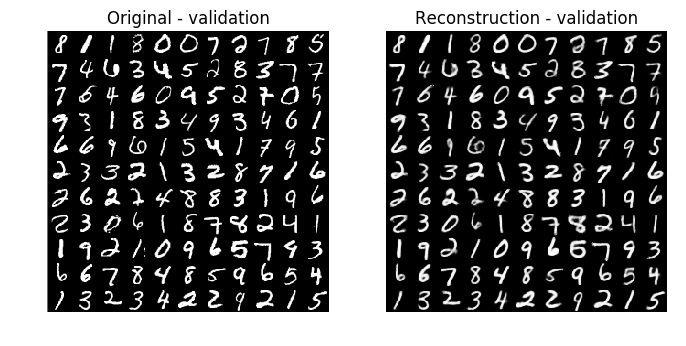

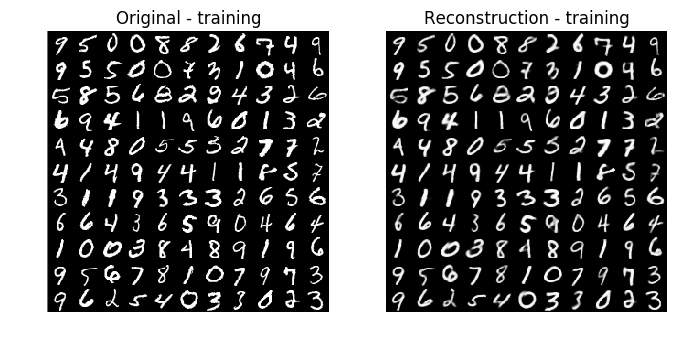

In [20]:
from IPython.display import Image, display, clear_output

if pretraining:
    print('Pretraining')
    #M1 pretraining
    for i in range(100000):
        idxs = np.random.choice(range(x_trai.shape[0]), size=(batch_size), replace=False) 
        x_batch = x_trai[idxs]
        f_train_M1(x_batch)
        if (i+1)%100==0:

            out=f_eval_M1(x_test)
            #print(samples_processed_M1,out[0].tolist(),out[1].tolist())

            ##Update Output dict
            output_dict['samples_processed_M1']+=[samples_processed_M1]
            samples_processed_M1+=batch_size*100
            output_dict['LL_valid_M1']+=[out[0].tolist()]
            output_dict['KL_M1']+=[out[1].tolist()]

        if (i+1)%1000==0:
            clear_output(wait=True)
            plt.subplot(2,2,1)
            pretty_print("KL_divergence",output_dict,['KL_M1'],M_type='_M1',show=False)
            plt.subplot(2,2,2)
            pretty_print("Loglikelihood",output_dict,['LL_valid_M1'],M_type='_M1',show=False)
            plt.show()
            plot_image_and_recon(x_test,'validation','M1')
            plot_image_and_recon(x_trai,'training','M1')

    #Combined training
    print('Pretraining finished')
    if save_weights:
        save_model(M1_model_name, x_rec_M1)    

else:
    load_model(M1_model_name, x_rec_M1)
    
        
clear_output(wait=True)
plot_image_and_recon(x_test,'validation','M1')
plot_image_and_recon(x_trai,'training','M1')  

sample,acc,     LL, cert_cl,cert_rec,rec_cl_same,KL_M1,KL_M2
(11000000, 0.9661, -105.01, 0.9989, 0.9927, 0.9459, 21.18, 23.95)


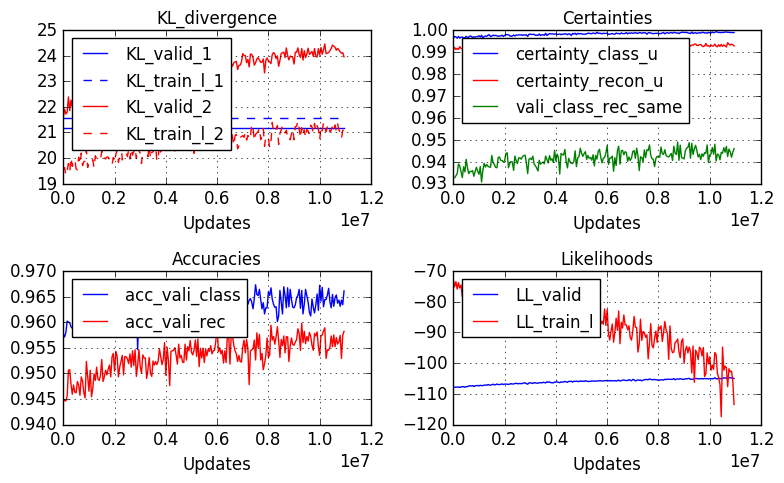

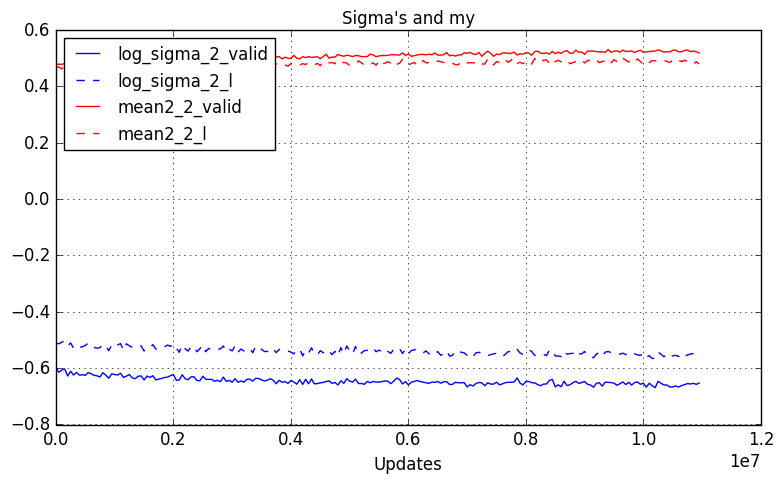

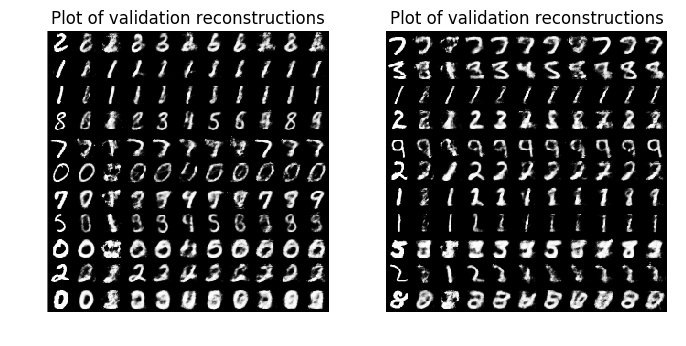

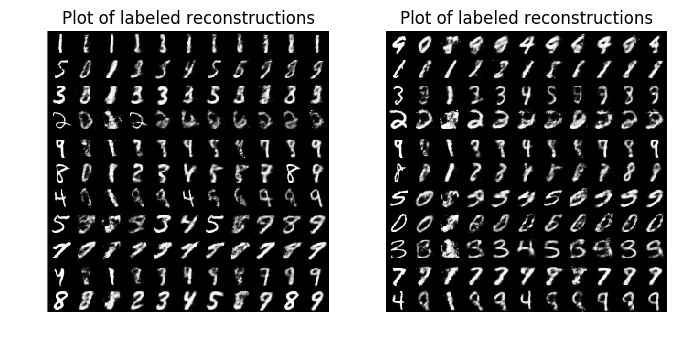

KeyboardInterrupt: 

In [21]:
from IPython.display import Image, display, clear_output
if load_M2:
    load_model(M2_model_name_in, [y_out, x_rec_M2])
plot_interval=500

for i in range(1000000):
    idxs = np.random.choice(range(x_trai.shape[0]), size=(batch_size), replace=False) 
    x_batch = x_trai[idxs]
    t_batch = t_trai[idxs]
    f_train_M2(x_batch,x_train_l,t_train_l)
#     if (i%10==0)&(i>10000):
#         f_train_M2_uns(x_batch)
#     else:
#         f_train_M1(x_batch)
    if (i+1)%100==0:
        out=f_eval_M2(x_test)
        
        print(samples_processed_M2,round(np.sum(np.equal(np.argmax(out[0],axis=1),
            np.argmax(t_test,axis=1)))/float(t_test.shape[0]),4),round(out[1].mean(),2)
             ,round(out[2].tolist(),4),round(out[3].tolist(),4),round(out[4].tolist(),4),round(out[5].tolist(),2),round(out[6].tolist(),2))
        ##Update Output dict
        output_dict['samples_processed_M2']+=[samples_processed_M2]
        samples_processed_M2+=batch_size*100
        output_dict['acc_vali_class']+=[np.sum(np.equal(np.argmax(out[0],axis=1),
            np.argmax(t_test,axis=1)))/float(t_test.shape[0])]
        output_dict['LL_valid']+=[out[1].tolist()]
        output_dict['certainty_class_u']+=[out[2].tolist()]
        output_dict['certainty_recon_u']+=[out[3].tolist()]
        output_dict['vali_class_rec_same']+=[out[4].tolist()]
        output_dict['KL_valid_1']+=[out[5].tolist()]
        output_dict['KL_valid_2']+=[out[6].tolist()]
        output_dict['acc_vali_rec']+=[np.sum(np.equal(np.argmax(out[7],axis=1),
            np.argmax(t_test,axis=1)))/float(t_test.shape[0])]
        output_dict['log_sigma_2_valid']+=[out[9].tolist()]
        output_dict['mean2_2_valid']+=[out[8].tolist()]


        # Output dict labeled
        out_l=f_eval_M2(x_train_l)
        output_dict['LL_train_l']+=[out_l[1].tolist()]
        output_dict['certainty_class_l']+=[out_l[2].tolist()]
        output_dict['certainty_recon_l']+=[out_l[3].tolist()]
        output_dict['KL_train_l_1']+=[out_l[5].tolist()]
        output_dict['KL_train_l_2']+=[out_l[6].tolist()]
        output_dict['log_sigma_2_l']+=[out_l[9].tolist()]
        output_dict['mean2_2_l']+=[out_l[8].tolist()]
        
        
    if (i+1)%plot_interval==0:
        clear_output(wait=True)
        print('sample,acc,     LL, cert_cl,cert_rec,rec_cl_same,KL_M1,KL_M2')
        print(samples_processed_M2,round(np.sum(np.equal(np.argmax(out[0],axis=1),
            np.argmax(t_test,axis=1)))/float(t_test.shape[0]),4),round(out[1].mean(),2)
             ,round(out[2].tolist(),4),round(out[3].tolist(),4),round(out[4].tolist(),4),round(out[5].tolist(),2),round(out[6].tolist(),2))

        plt.subplot(2,2,1)
        pretty_print("KL_divergence",output_dict,['KL_valid_1','KL_valid_2'],['KL_train_l_1','KL_train_l_2'],show=False)
        plt.subplot(2,2,2)
        pretty_print("Certainties",output_dict,['certainty_class_u','certainty_recon_u','vali_class_rec_same'],show=False)
        plt.subplot(2,2,3)
        pretty_print("Accuracies",output_dict,['acc_vali_class','acc_vali_rec'],show=False)
        plt.subplot(2,2,4)
        pretty_print("Likelihoods",output_dict,['LL_valid','LL_train_l'],show=False)
        plt.show()
        pretty_print("Sigma's and my",output_dict,['log_sigma_2_valid','mean2_2_valid'],['log_sigma_2_l','mean2_2_l'],show=False)
        plt.show()
        plot_image_and_recon(x_test,'Plot of validation reconstructions')
        plot_image_and_recon(x_train_l,'Plot of labeled reconstructions')
        plt.show()
if save_M2:
    save_model(M2_model_name_out, [y_out, x_rec_M2])

'models/M2_pretrained'

In [23]:
# ! conda install nomkl

In [24]:
augment_image(x_trai[25+i].reshape((1,num_features)).shape

SyntaxError: unexpected EOF while parsing (<ipython-input-24-f64f3dc663aa>, line 1)

In [ ]:
x_plot=x_trai[np.random.choice(range(x_trai.shape[0]), size=(num_classes+1), replace=False)]
x_plot_recon = f_reconstruction(x_plot)[0]
print('1')
x_plot_comb=np.zeros(((num_classes+1)*(num_classes+2),num_features))
for i in range(num_classes+1):
    x_plot_comb[i*(num_classes+1)]=x_plot[i]
    #x_plot_comb[range(i*(num_classes+1)+1,(i+1)*(num_classes+1))]=x_plot_recon[range(i*num_classes,(i+1)*num_classes)]
    x_plot_comb[range(i*(num_classes+1)+1,(i+1)*(num_classes+1))]=x_plot_recon[np.array(range(num_classes))*(num_classes+1)+i]
org_plot=tls.plot_svhn(x_plot_comb, 
                                 t=num_classes+1, cmap=cmap, IMG_LEN=IMG_LEN, 
                                 IMG_DEPTH=IMG_DEPTH,choose_random=False)
#print(type(org_plot),org_plot)
_, ax = plt.subplots(1,2)
ax[0].imshow(org_plot[0], cmap=cmap, interpolation='None')
ax[0].set_title('Original - labeled')
ax[0].axis('off')
plt.show()


Tiløjet: L2, image augmentation

In [ ]:
LL_train_u=-2000
LL_train_l=-1900
max_like=np.max([-LL_train_u,-LL_train_l])
LL_train=-(max_like+np.log(1/2*np.exp(-LL_train_l-max_like)+1/2*np.exp(-LL_train_u-max_like)))

In [ ]:
LL_train

In [ ]:
max_like=np.max([-LL_train_u,-LL_train_l])
print(max_like,-LL_train_l-max_like,-LL_train_u-max_like)